# Importing dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from scipy import stats

This notebook solves task of flight delay estimation. 

Used predictors:

- Departure airport
- Destination airport
- Departure Month
- Departure Day of the Week
- Flight Duration

Used models:

- Linear regression
- Linear regression with Lasso regularization
- Polynomial regression

### Analyzing dataset

In [3]:
dataset = pd.read_csv('./flight_delay.csv')

print(f'{dataset.head().to_string()}\n')
print(f'{dataset.shape}\n')
types = dataset.dtypes
print("Number categorical featues:", sum(types=='object'))
print(f'{types}\n')
print(dataset.describe().to_string())
print(f"{dataset['Delay'].value_counts()}\n")

  Depature Airport Scheduled depature time Destination Airport Scheduled arrival time  Delay
0              SVO     2015-10-27 07:40:00                 HAV    2015-10-27 20:45:00    0.0
1              SVO     2015-10-27 09:50:00                 JFK    2015-10-27 20:35:00    2.0
2              SVO     2015-10-27 10:45:00                 MIA    2015-10-27 23:35:00    0.0
3              SVO     2015-10-27 12:30:00                 LAX    2015-10-28 01:20:00    0.0
4              OTP     2015-10-27 14:15:00                 SVO    2015-10-27 16:40:00    9.0

(675513, 5)

Number categorical featues: 4
Depature Airport            object
Scheduled depature time     object
Destination Airport         object
Scheduled arrival time      object
Delay                      float64
dtype: object

               Delay
count  675513.000000
mean        9.912939
std        44.895875
min         0.000000
25%         0.000000
50%         0.000000
75%         5.000000
max      1436.000000
0.0       391070
1.

### Label encoding

In [4]:
encoder = LabelEncoder()
cat_feat_1 = ['Destination Airport']
cat_feat_2 = ['Depature Airport']
print(f'Number of unique Destination Airports {dataset[cat_feat_1].nunique()} \n')
print(f'Number of unique Destination Airports {dataset[cat_feat_2].nunique()} \n')
dataset["Destination Airport"] = encoder.fit_transform(dataset[cat_feat_1])
dataset["Depature Airport"] = encoder.fit_transform(dataset[cat_feat_2])

Number of unique Destination Airports Destination Airport    177
dtype: int64 

Number of unique Destination Airports Depature Airport    179
dtype: int64 



/home/ravil/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Exctracting new features

In [5]:
dataset['Scheduled depature time'] = pd.to_datetime(dataset['Scheduled depature time'])
dataset['Departure Month'] = dataset['Scheduled depature time'].dt.month
dataset['Departure Day of the Week'] = dataset['Scheduled depature time'].dt.dayofweek
dataset['Departure Year'] = dataset['Scheduled depature time'].dt.year
# Arrival time processing
dataset['Scheduled arrival time'] = pd.to_datetime(dataset['Scheduled arrival time'])
# Time difference
dataset['Pre_Flight Duration'] = dataset['Scheduled arrival time'] - dataset['Scheduled depature time']
dataset['Flight Duration'] = dataset['Pre_Flight Duration'].dt.seconds / 60 
# Dropping unnessecary features
dataset.drop(['Scheduled depature time', 'Scheduled arrival time', 'Pre_Flight Duration'], axis=1, inplace = True)

### Imputing and Scaling

In [6]:
print('\t\t\t Imputing and Scaling\n')
def count_nans(df):
    return np.sum(np.sum(np.isnan(df)))
print("Empty cells in x_train=", count_nans(dataset))
print('No empty cells. So no Imputing is needed')

scaler = RobustScaler()
dataset["Flight Duration"] = scaler.fit_transform(dataset["Flight Duration"].values[:, None])
dataset["Depature Airport"] = scaler.fit_transform(dataset["Depature Airport"].values[:, None])
dataset["Destination Airport"] = scaler.fit_transform(dataset["Destination Airport"].values[:, None])
print(25 * '-' + 25 * ' ' + 25 * '-')

			 Imputing and Scaling

Empty cells in x_train= 0
No empty cells. So no Imputing is needed
-------------------------                         -------------------------


### Splitting dataset

In [7]:
train_data = dataset[dataset['Departure Year'] < 2018]
test_data = dataset[dataset['Departure Year'] >= 2018]
# Drop unnessecary features
train_data.drop(['Departure Year'], axis=1, inplace = True)
test_data.drop(['Departure Year'], axis=1, inplace = True)
x_test = test_data.drop('Delay', axis=1)
y_test = test_data['Delay']

/home/ravil/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Printing the data

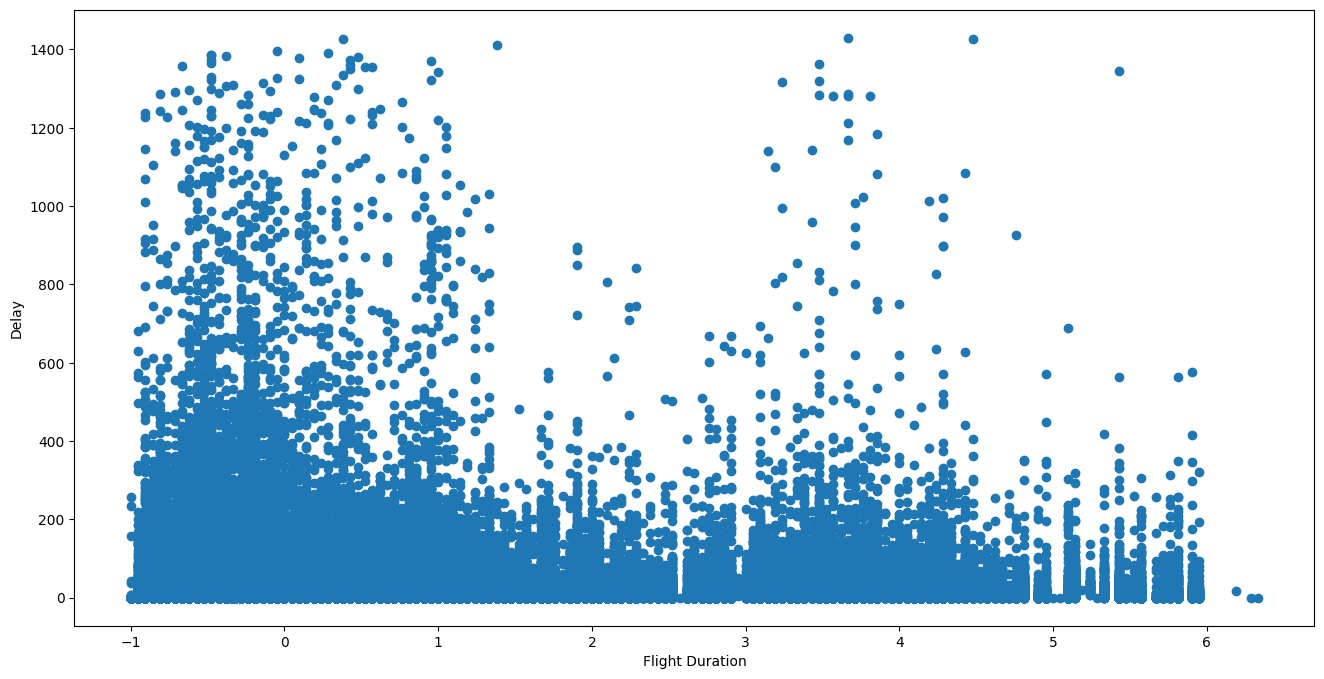

In [8]:
fig, ax = plt.subplots(figsize = (16,8))
ax.scatter(train_data['Flight Duration'], train_data['Delay'])
ax.set_xlabel('Flight Duration')
ax.set_ylabel('Delay')
plt.show()

### Outlier Detection and Removal

In [9]:
#cheching for 1 month (approximately 2% = 15000 samples)
threshold = 3
sample = train_data[0:15000]
z = np.abs(stats.zscore(sample))
out_indexes = np.where(z > threshold)
unique_indexes = np.unique(out_indexes[0])
print(f' Number of outliers: {len(unique_indexes)}')

 Number of outliers: 540


In [10]:
# applying for whole dataset
z = np.abs(stats.zscore(train_data))
out_indexes = np.where(z > threshold)
unique_indexes = np.unique(out_indexes[0])
print(f' Number of outliers: {len(unique_indexes)}\n')

 Number of outliers: 19970



In [11]:
# Removing the outliers
train_data = train_data[(z < 3).all(axis=1)]

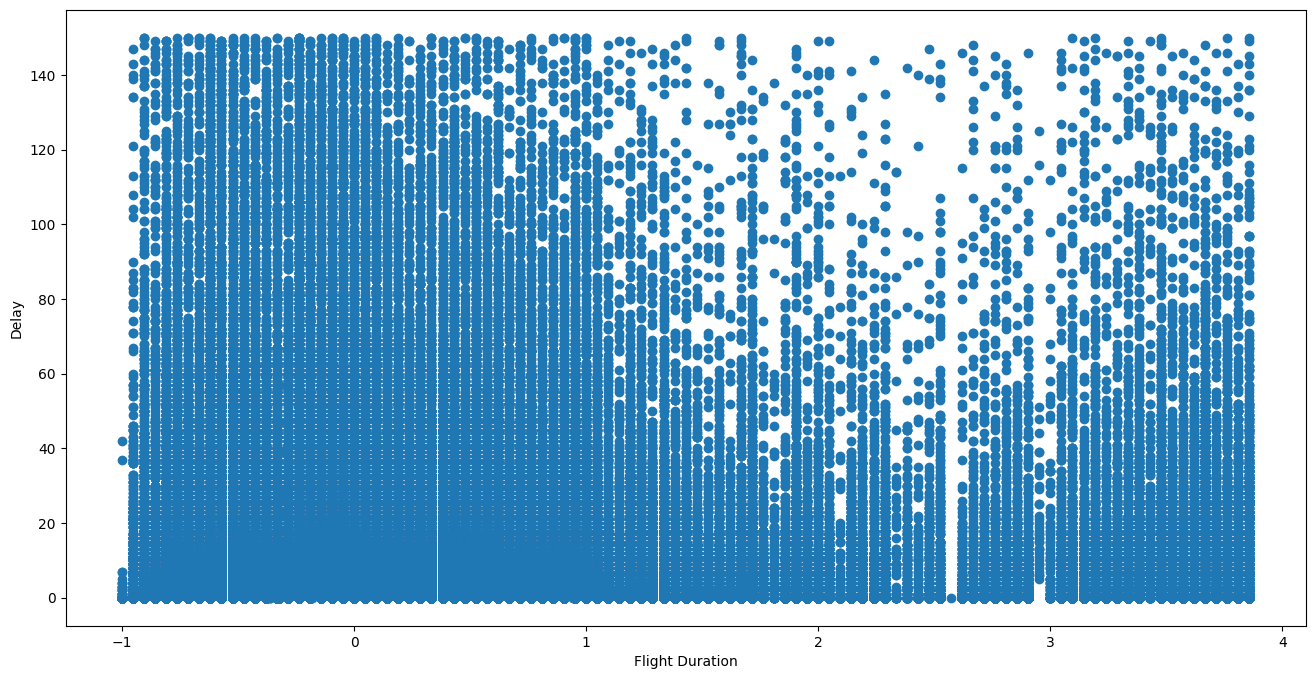

In [12]:
# Scatter plot
fig, ax = plt.subplots(figsize = (16,8))
ax.scatter(train_data['Flight Duration'], train_data['Delay'])
ax.set_xlabel('Flight Duration')
ax.set_ylabel('Delay')
plt.show()

### Splitting the data

In [13]:
# Deriving x_train and y_train
x_train = train_data.drop('Delay', axis=1)
y_train = y_train = train_data['Delay']

print('X_train dataframe:\n')
print(x_train.head().to_string())
print(25 * '-' + 25 * ' ' + 25 * '-')

X_train dataframs:

   Depature Airport  Destination Airport  Departure Month  Departure Day of the Week  Flight Duration
4         -0.508197                 0.00               10                          1        -0.142857
5         -1.491803                 0.00               10                          1         0.047619
7         -1.786885                 0.00               10                          1         1.714286
8          0.000000                 0.45               10                          1         3.285714
9          0.196721                 0.00               10                          1         0.857143
-------------------------                         -------------------------


### Linear regression

In [14]:
print('Linear regression\n')
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
print(f"Model intercept : {lin_regr.intercept_}")
print(f"Model coefficients : {lin_regr.coef_}\n")
y_pred = lin_regr.predict(x_test)

print('Root MSE for linear regression:', metrics.mean_squared_error(y_test, y_pred, squared=False))
print('MAE for linear regression:', metrics.mean_absolute_error(y_test, y_pred))
print('R2 score for linear regression', metrics.r2_score(y_test, y_pred),'\n')

train_pred = lin_regr.predict(x_train)
print('Root MSE for linear regression on test data:', metrics.mean_squared_error(y_train, train_pred, squared=False))
print('MAE for linear regression on test data:', metrics.mean_absolute_error(y_train, train_pred))
print('R2 score for linear regression on test data:', metrics.r2_score(y_train, train_pred))

Linear regression

Model intercept : 6.572694650834772
Model coefficients : [-0.30591856  0.69042988  0.04003619  0.03946379  1.65849744]

Root MSE for linear regression: 39.971976018842106
MAE for linear regression: 11.317130609969723
R2 score for linear regression 0.003127563582537407 

Root MSE for linear regression on test data: 17.05490530961331
MAE for linear regression on test data: 9.35985741359131
R2 score for linear regression on test data: 0.00929298228503117


### Lasso regression

In [15]:
print('Lasso regression\n')                                                       
lasso = Lasso()
gridParams = {"alpha": np.linspace(0.1, 4, 5)}
grid = GridSearchCV(lasso, gridParams, scoring='neg_mean_squared_error',
                    verbose=1, n_jobs=-1, cv=5)
grid.fit(x_train, y_train)           
print("Best params:", grid.best_params_)
print("Root MSE for lasso regression:", metrics.mean_squared_error(y_test, grid.predict(x_test), squared=False))
print("MAE for lasso regression:", metrics.mean_absolute_error(y_test, grid.predict(x_test)))
print("R2 score for lasso regression:", metrics.r2_score(y_test, grid.predict(x_test)),'\n')

pred_train = grid.predict(x_train)
print(f"Root MSE for lasso regression on train dataset:", metrics.mean_squared_error(y_train, pred_train, squared=False))
print(f"MAE for lasso regression on train dataset:", metrics.mean_absolute_error(y_train, pred_train))
print("R2 score for lasso regression on train dataset:", metrics.r2_score(y_train, pred_train),'\n')

print(25 * '-' + 25 * ' ' + 25 * '-')

Lasso regression

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'alpha': 0.1}
Root MSE for lasso regression: 39.9760383263855
MAE for lasso regression: 11.33178191921925
R2 score for lasso regression: 0.0029249312085638524 

Root MSE for lasso regression on train dataset: 17.056120904393858
MAE for lasso regression on train dataset: 9.369117689815862
R2 score for lasso regression on train dataset: 0.009151751222608806 

-------------------------                         -------------------------


### Polynomial regression

In [16]:
degrees = [1, 2, 3, 4, 5]
print('Polynomial regression\n')  
for degree in degrees:
    poly = PolynomialFeatures(degree)
    poly.fit(x_train)
    polyXtrain = poly.transform(x_train)
    polyXtest = poly.transform(x_test)
    lr = LinearRegression()
    lr.fit(polyXtrain, y_train)
    pred = lr.predict(polyXtest)
    print(f"Root MSE for polynomial regression with degree {degree} :", metrics.mean_squared_error(y_test, pred, squared=False))
    print(f"MAE for polynomial regression with degree {degree} :", metrics.mean_absolute_error(y_test, pred))
    print(f"R2 score  for polynomial regression with degree {degree} :", metrics.r2_score(y_test, pred),'\n')

    pred_train = lr.predict(polyXtrain)
    print(f"Root MSE for polynomial regression with degree {degree} on train dataset:", metrics.mean_squared_error(y_train, pred_train,squared=False))
    print(f"MAE for polynomial regression with degree {degree} on train dataset:", metrics.mean_absolute_error(y_train, pred_train))
    print(f"R2 score  for polynomial regression with degree {degree} :", metrics.r2_score(y_train, pred_train))
    print(25 * '-' + 25 * ' ' + 25 * '-')

Polynomial regression

Root MSE for polynomial regression with degree 1 : 39.97197601884211
MAE for polynomial regression with degree 1 : 11.317130609969672
R2 score  for polynomial regression with degree 1 : 0.003127563582537185 

Root MSE for polynomial regression with degree 1 on train dataset: 17.054905309613307
MAE for polynomial regression with degree 1 on train dataset: 9.359857413591273
R2 score  for polynomial regression with degree 1 : 0.009292982285031282
-------------------------                         -------------------------
Root MSE for polynomial regression with degree 2 : 39.89148502604135
MAE for polynomial regression with degree 2 : 11.100534424943866
R2 score  for polynomial regression with degree 2 : 0.007138296689733203 

Root MSE for polynomial regression with degree 2 on train dataset: 17.014396790198827
MAE for polynomial regression with degree 2 on train dataset: 9.300054161910708
R2 score  for polynomial regression with degree 2 : 0.013993613947890116
-----

Analysis of the work is in "Ravil_ML_1.pdf"